In [24]:
import pandas as pd

df = pd.read_csv('./data/november_full_data.csv')

print(df.tail())


                        airline airline_code  num_code  dep_time  time_taken  \
60423               Vietjet Air           VJ       539  17:00:00         120   
60424           Vietnam Airline          VNA       828  07:00:00         120   
60425           Vietnam Airline          VNA       832  07:05:00         120   
60426           Vietnam Airline          VNA       828  07:00:00         120   
60427  Jetstar Pacific Airlines           BL       305  08:15:00         120   

         price Routine departure_time  
60423  1892400   CT-HN        Evening  
60424  2172000   CT-HN        Morning  
60425  2533200   CT-HN        Morning  
60426  2781600   CT-HN        Morning  
60427  2999700   CT-HN        Morning  


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60428 entries, 0 to 60427
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   airline         60428 non-null  object
 1   airline_code    60428 non-null  object
 2   num_code        60428 non-null  int64 
 3   dep_time        60428 non-null  object
 4   time_taken      60428 non-null  int64 
 5   price           60428 non-null  int64 
 6   Routine         60428 non-null  object
 7   departure_time  60428 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.7+ MB


In [26]:
df_encoded = df.copy()

airline_mapping = {airline: index for index, airline in enumerate(df['airline'].unique())}
df_encoded['airline'] = df['airline'].map(airline_mapping)

airline_code_mapping = {code: index for index, code in enumerate(df['airline_code'].unique())}
df_encoded['airline_code'] = df['airline_code'].map(airline_code_mapping)

df_encoded['dep_time'] = pd.to_datetime(df['dep_time']).dt.hour + pd.to_datetime(df['dep_time']).dt.minute / 60

departure_time_mapping = {time: index for index, time in enumerate(df['departure_time'].unique())}
df_encoded['departure_time'] = df['departure_time'].map(departure_time_mapping)

routine_mapping = {routine: index for index, routine in enumerate(df['Routine'].unique())}
df_encoded['Routine'] = df['Routine'].map(routine_mapping)

print(df_encoded[['airline', 'airline_code', 'Routine', 'dep_time', 'departure_time']].head())


   airline  airline_code  Routine   dep_time  departure_time
0        0             0        0   5.750000               0
1        0             0        0  20.666667               1
2        0             0        0  21.666667               1
3        0             0        0   9.500000               2
4        0             0        0  12.833333               3


C:\Users\dinhg\AppData\Local\Temp\ipykernel_1576\1581113506.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_encoded['dep_time'] = pd.to_datetime(df['dep_time']).dt.hour + pd.to_datetime(df['dep_time']).dt.minute / 60
C:\Users\dinhg\AppData\Local\Temp\ipykernel_1576\1581113506.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_encoded['dep_time'] = pd.to_datetime(df['dep_time']).dt.hour + pd.to_datetime(df['dep_time']).dt.minute / 60


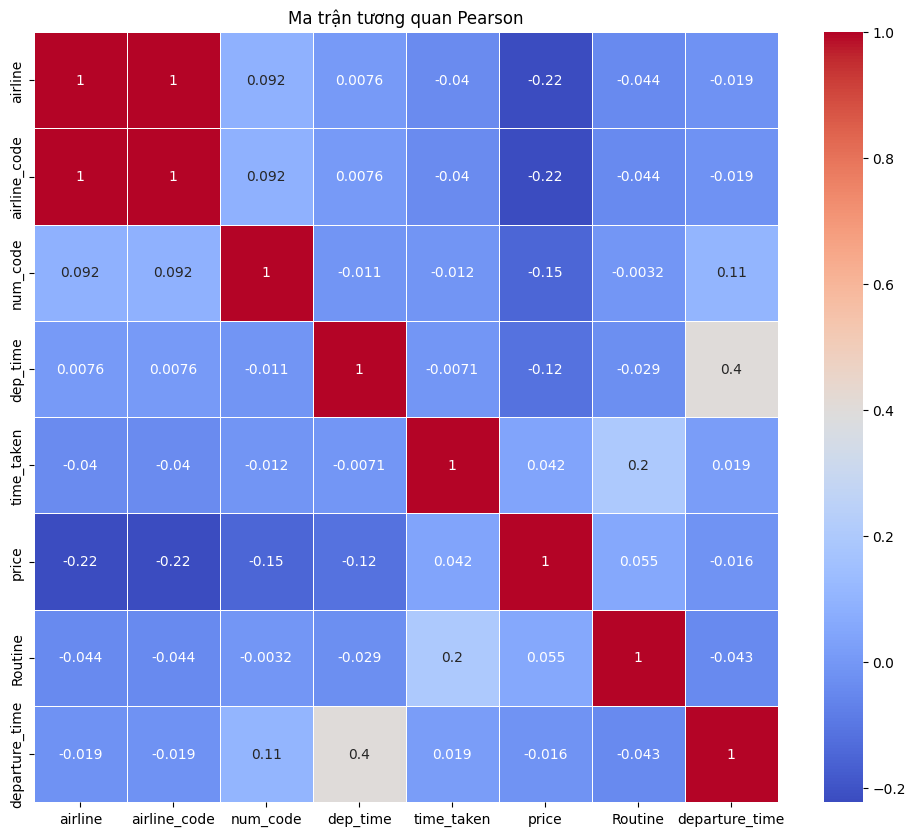

Các cặp tương quan cao nhất:
Series([], dtype: float64)


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan Pearson')
plt.show()

print("Các cặp tương quan cao nhất:")
corr_pairs = correlation_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)
print(sorted_pairs[(sorted_pairs < 1.0) & (sorted_pairs > 0.5)])


In [28]:
df.to_csv('./data/november_full_data_encoded.csv', index=False)
